# MPD Quality Assurance (QA) Process

## Summary

This Jupyter Notebook presents a fundamental framework for conducting quality assurance on Mobile Positioning Data (MPD) with the aim of ensuring its accuracy, reliability, and suitability for further analysis.

The underlying principle of quality assurance is to ascertain the adequacy of the data for subsequent analysis. Key considerations include the rate of data records per unit time, the completeness of data for each variable, and discerning data patterns.

The primary objective of this notebook is to execute diverse quality assurance checks on the MPD dataset in order to guarantee its reliability and consistency.

The quality assurance process will entail the examination of multiple metrics to validate the reliability and consistency of the MPD dataset. The following metrics will be scrutinized:

1. Generation of user/subscriber statistics

2. Evaluation of the percentage of null values for each column

3. Assessment of the consistency in the number of subscribers per day

4. Verification of the consistency in the number of unique cell locations

5. Examination of the location of cell IDs outside the mainland

6. Analysis of the distribution of active days for subscribers (day present)

7. Evaluation of the diurnal distribution of subscribers' activity

## Quality Assurance Metrics

### 1. Generation of user/subscriber statistics
This metric involves generating comprehensive statistics on the users and subscribers present in the MPD.

### 2. Checking Percentage of Null Values
The first metric focuses on assessing the percentage of null values in each column of the MPD dataset. By identifying the presence of null values, which indicate missing or incomplete data, we can evaluate the data completeness and take appropriate measures to address any gaps.

### 3. Checking Consistency of Number of Subscribers
This metric aims to ensure the consistency of the recorded number of subscribers on a daily basis within the MPD dataset. By examining the fluctuations or discrepancies in subscriber counts, we can identify potential data quality issues, such as data entry errors or inconsistencies in data collection processes.

### 4. Checking Consistency of Number of Unique Cell Locations
This metric examines the consistency of the count of unique cell locations within the MPD dataset. Consistent counts indicate a reliable dataset, while inconsistencies may suggest data quality issues or errors in recording cell locations. By verifying the consistency, we can ensure the accuracy and integrity of the location data.

### 5. Checking the Location of Cell IDs
This metric focuses on verifying the geographical locations associated with cell IDs in the MPD dataset. Specifically, it checks whether any cell locations are recorded outside the mainland. Identifying such outliers or data points that deviate from the expected geographical coverage helps maintain data accuracy and prevent misleading analyses.

### 6. Checking the Active Day Distribution of Subscribers
This metric involves analyzing the distribution of active days for subscribers in the MPD dataset. By examining patterns and anomalies in subscriber activity, such as variations in usage on specific days, we can gain insights into user behavior and usage trends. Understanding the distribution of active days is crucial for evaluating network reliability and optimizing resource allocation.

### 7. Checking the Diurnal Distribution of Subscribers Activity
This metric focuses on examining the diurnal distribution of subscribers' activity throughout the day within the MPD dataset. By studying peak usage hours, low-usage periods, and any abnormal patterns in subscriber activity, we can gain valuable insights into user behavior and usage patterns. Analyzing the diurnal distribution helps optimize network resources and enhance service quality.

By conducting these quality assurance checks, we can ensure the reliability, accuracy, and consistency of the MPD dataset, thereby enabling more robust analysis and informed decision-making based on the mobile positioning data.

## QA Acceptance Rate
This code defines two Python dictionaries, `CONF` and `QA_summary`, used in a quality assurance (QA) process. 

The `DIURNAL_REFERENCE` list contains values that define an expected distribution with an elephant shape. This is used as a reference for a QA test later on.

`CONF` is initialized with a set of threshold values including:

- `NULL_MAX_THRESHOLD`: the maximum number of null values allowed in a data set
- `SUBS_MIN_THRESHOLD`: the minimum value for a substitution score in user statistics
- `CELL_MIN_THRESHOLD`: the minimum value for a cell consistency score
- `CELL_OOB_MAX_THRESHOLD`: the maximum percentage of out-of-bounds cells allowed
- `ACTIVE_DAY_SKEWNESS_THRESHOLD`: the skewness threshold for an active day distribution
- `DIURNAL_DISTRIBUTION_REFERENCE`: the `DIURNAL_REFERENCE` list defined earlier
- `DIURNAL_DISTRIBUTION_PVALUE`: the p-value threshold for a diurnal distribution test

`QA_summary` is initialized with seven different keys corresponding to different types of QA tests that will be run. The values for each key are a tuple containing two items: the status (which can be "NOT RUN,", "OBSERVED", "PASSED," or "FAILED"), and the report (which may describe what was tested, how it was tested, and any issues found).

In [146]:
# Import the sys module to adjust the Python system path
import sys

# Append a path to the system path so that Python can import modules from the specified directory (relative path)
sys.path.append('../')

# Import the CONF, QA_summary and QA_action_plan variables from the script.QA module
from script.conf import *

In [147]:
# Import the os module to interact with the operating system
import os

# Try to create a new directory at the path QA_PATH using os.mkdir()
# If the directory already exists, print a message stating that it does
try:
    os.mkdir(QA_PATH)
    print("Create new folder {}".format(QA_PATH))
except FileExistsError:
    print("Folder {} already exists".format(QA_PATH))


Folder ../data/02_QA/ already exists


## 1. Generation of user/subscriber statistics

This metric involves generating comprehensive statistics on the users and subscribers present in the MPD dataset.

### Create Spark Session

In [148]:
# Import Pandas module
import pandas as pd

# Import the PySpark module
import pyspark

import pyspark.sql.functions as f
from pyspark.sql.functions import year, month, dayofmonth, substring, col, to_date
from pyspark.sql.window import Window

# Import the SparkSession from PySpark
from pyspark.sql import SparkSession

# Set number of core. * will takes all the available cores.
CORE = "*"

# Create a SparkSession with the specified configuration
spark = SparkSession.builder\
        .master("local[{}]".format(CORE))\
        .appName("02.ITU.PySpark-QA")\
        .config('spark.sql.execution.arrow.pyspark.enabled', 'true')\
        .config('spark.eventLog.gcMetrics.youngGenerationGarbageCollectors', 'true')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Print the spark object which contains the SparkSession
spark

In [149]:
# Use this code below to connect your remote spark cluster instead.

# # Import the PySpark module
# import pyspark
# from pyspark.sql.types import StructType, StructField, StringType, FloatType, TimestampType

# import pyspark.sql.functions as f
# from pyspark.sql.functions import year, month, dayofmonth, substring, col, to_date
# from pyspark.sql.window import Window

# # Import the SparkSession from PySpark
# from pyspark.sql import SparkSession

# CLUSTER_URL = "spark://master"
# PORT = "7077"

# # Create a SparkSession with the specified configuration remote server
# spark = SparkSession.builder\
#         .master("{}:{}".format(CLUSTER_URL,PORT))\
#         .appName("01.ITU.PySpark-Raw")\
#         .getOrCreate()

# # Print the spark object which contains the SparkSession
# spark

### Load the MPD dataset using PySpark

In [150]:
# Read in parquet file using Apache Spark's DataFrame API
df = spark.read.format('parquet')\
    .load(BASE_PATH+QA_FILE_PATH)

df.show(5)

# Print the number of records in the DataFrame
print("Number of records: {}".format(df.count()))

+-------------------+-------+--------+---------+---------+-------+----------+------+
|           datetime|cell_id|latitude|longitude|data_type|service|      date|msisdn|
+-------------------+-------+--------+---------+---------+-------+----------+------+
|2024-11-04 00:04:00|  100.0|  43.209|   -3.177|      CDR|     2G|2024-11-04|    48|
|2024-11-04 06:38:00|  100.0|  43.209|   -3.177|      CDR|     2G|2024-11-04|    48|
|2024-11-04 00:36:00|  100.0|  43.209|   -3.177|      CDR|     2G|2024-11-04|    48|
|2024-11-04 05:07:00|  100.0|  43.209|   -3.177|      CDR|     2G|2024-11-04|    48|
|2024-11-04 03:44:00|  100.0|  43.209|   -3.177|      CDR|     2G|2024-11-04|    48|
+-------------------+-------+--------+---------+---------+-------+----------+------+
only showing top 5 rows

Number of records: 236580


To calculate the user statistics, we need to aggregate the data at the user level.

The `groupBy` method groups the rows of the DataFrame by the 'msisdn' column. Then, the `agg` method aggregates the columns of the grouped Dataframe to compute several statistics for each 'msisdn'. These variables are:
- `total_events`: Total events for each msisdn.
- `CDR_events`: Count of CDR events for each msisdn.
- `IPDR_events`: Count of IPDR events for each msisdn.
- `total_date`: Total dates for each msisdn.
- `CDR_date`: Count of CDR dates for each msisdn.
- `IPDR_date`: Count of IPDR dates for each msisdn,
- `start_date`: The earliest date for each msisdn.
- `end_date`: The latest date for each msisdn.

The resulting dataframe is then converted into a pandas dataframe and saved as a CSV file with semicolon separator.

In [151]:
from pyspark.sql.functions import count,countDistinct, when, col, min, max 

# This code calculates statistics for each user and exports the results to a CSV file
user_stats = df.groupBy('msisdn')\
    .agg(
        count('datetime').alias('total_events'), # Counting total events for each msisdn
        count(when(col('data_type')=='CDR',col('datetime'))).alias('CDR_events'), # Counting CDR events for each msisdn
        count(when(col('data_type')=='IPDR',col('datetime'))).alias('IPDR_events'), # Counting IPDR events for each msisdn
        countDistinct(col('date')).alias('total_date'), # Counting total dates for each msisdn
        countDistinct(when(col('data_type')=='CDR',col('date'))).alias('CDR_date'), # Counting CDR dates for each msisdn
        countDistinct(when(col('data_type')=='IPDR',col('date'))).alias('IPDR_date'), # Counting IPDR dates for each msisdn
        min(col('date')).alias('start_date'), # Finding the start date for each msisdn
        max(col('date')).alias('end_date'), # Finding the end date for each msisdn
    )

# Displays the first 5 rows of the user_stats dataframe
user_stats.show(5)

+------+------------+----------+-----------+----------+--------+---------+----------+----------+
|msisdn|total_events|CDR_events|IPDR_events|total_date|CDR_date|IPDR_date|start_date|  end_date|
+------+------------+----------+-----------+----------+--------+---------+----------+----------+
|    31|         837|       202|        635|       186|      84|      166|2024-05-10|2024-12-22|
|    85|        2569|       237|       2332|       229|      82|      229|2024-05-10|2024-12-24|
|    65|        2754|        73|       2681|       228|      27|      228|2024-05-10|2024-12-25|
|    53|        3084|       174|       2910|       226|      55|      225|2024-05-10|2024-12-21|
|    78|        1998|       266|       1732|       220|     102|      216|2024-05-10|2024-12-22|
+------+------------+----------+-----------+----------+--------+---------+----------+----------+
only showing top 5 rows



In [152]:
# Converts the user_stats dataframe to a pandas dataframe
user_stats_df = user_stats.toPandas()

# Finds the minimum start date and maximum end date for all users in the user_stats dataframe
start_date = user_stats_df['start_date'].min()
end_date = user_stats_df['end_date'].max()

# Calculates the number of unique subscribers, the number of subscribers with CDR events, and the number of subscribers with IPDR events 
n_subs = len(user_stats_df)
n_subs_CDR = len(user_stats_df.query('CDR_events > 0'))
n_subs_IPDR = len(user_stats_df.query('IPDR_events > 0'))

# Generates the user statistics report and saves it as text
user_stats_report = """Overall start date\t\t: {}
Overall end date\t\t: {}
Subs. with CDR & IPDR\t: {}
Subs. with CDR only\t\t: {}
Subs. with IPDR only\t: {}""".format(start_date,end_date,n_subs,n_subs_IPDR,n_subs_CDR)

# Displays the user statistics report
print(user_stats_report)

# Adds the user statistics report to the QA_summary dictionary
QA_summary["USER_STATS_REPORT"] = ("OBSERVED",user_stats_report)

Overall start date		: 2024-05-10
Overall end date		: 2024-12-27
Subs. with CDR & IPDR	: 100
Subs. with CDR only		: 100
Subs. with IPDR only	: 99


In [153]:
# Defines where to save the resulting csv file
targeted_path_csv = QA_PATH+"1_users_stats.csv"

# Save dataframe to a csv file with tab-separated values
user_stats_df.to_csv(targeted_path_csv, index=False, sep="\t")

## 2. Checking Percentage of Null Values

This quality assurance metric focuses on identifying the percentage of null values in each column of the Mobile Positioning Data (MPD) dataset. Null values, also known as missing values, can indicate incomplete or unavailable data. It is essential to assess the extent of missing values in the dataset as they can impact subsequent analysis and decision-making processes.

To perform this check, follow the steps below:

1. Calculate the percentage of null values for each column.
2. Present the results in a clear and readable format.

It is recommended to visualize the percentage of null values using a bar chart or a heat map to gain a better understanding of the distribution of missing values across different columns.

Make sure to have the necessary libraries installed (`PySpark, Matplotlib, Seaborn`) before running the code. Adjust the figure size and other visual settings as desired.

### Calculate the percentage of null values for each column

This code calculates the percentage of null values for each column in a pandas DataFrame called df. 

- The first step is to calculate the total number of records in the DataFrame using the `count()` method and store it in a variable named `total_records`.
- Next, an empty list called `null_percentages` is created which will eventually be populated with the percentage of null values for each column.
- A for loop is then used to iterate over each column in the DataFrame using the columns attribute. Within the loop, the number of null values for each column is calculated by filtering the DataFrame on each column and using the `isNull()` method to identify null values. The count() method is then used to count the number of null values for that column and stored in a variable called null_count. The percentage of null values for that column is then calculated by dividing the null_count by the total_records.

In [154]:
total_records = df.count()   # count the total number of records

null_percentages = []   # create an empty list to store the null percentages for each column

# loop through each column of the dataframe
for column in df.columns:
    null_count = df.filter(df[column].isNull()).count()  # count the number of null values in the current column
    null_percentage = (null_count / total_records) * 100   # calculate the percentage of null values in the current column
    null_percentages.append([column, null_percentage])    # append the column name and null percentage to the null_percentages list

# create a new dataframe with the null percentages for each column
null_percentages_df = pd.DataFrame(null_percentages, columns=["Column", "NullPercentage"])

# sort the dataframe in descending order of null percentages
null_percentages_df = null_percentages_df.sort_values("NullPercentage", ascending=False)

# find the maximum null percentage value
max_null = null_percentages_df['NullPercentage'].max()

# check if the max null percentage is greater than the maximum threshold specified in the CONF dictionary
null_report = ""

if (max_null)>QA_CONF['NULL_MAX_THRESHOLD']:
    null_report = ("FAILED",'Null values is greater than threshold: {}%.'.format(max_null))
else:
    null_report = ("PASSED",'Null values is lower than threshold: {}%.'.format(max_null))

print(null_report)
QA_summary['NULL_REPORT'] = null_report

# display the entire null_percentages_df dataframe
null_percentages_df


('PASSED', 'Null values is lower than threshold: 0.0%.')


Column  NullPercentage
0   datetime             0.0
1    cell_id             0.0
2   latitude             0.0
3  longitude             0.0
4  data_type             0.0
5    service             0.0
6       date             0.0
7     msisdn             0.0

### Display the result using stacked bar chart

This code performs the following operations:

* Imports the necessary libraries for plotting charts (`seaborn` and `matplotlib.pyplot`).
* Sets the style of the grid.
* Creates a new figure with a specific size.
* Uses the `sns` library to plot a stacked bar chart using the `barplot()` method. It takes the following arguments:
	* `x`: the column used for the horizontal axis (i.e., the null percentage values).
	* `y`: the column used for the vertical axis (i.e., the column names).
	* `data`: the DataFrame containing the data to be plotted.
	* `orient`: the orientation of the bars (it is set to "h" for horizontal bars).
	* `palette`: the color palette to use for the bars.
* Sets the chart title, x-axis label, y-axis label, and the target path to save the image.
* Saves the chart as an image file at the specified location.
* Shows the plotted chart on the screen.

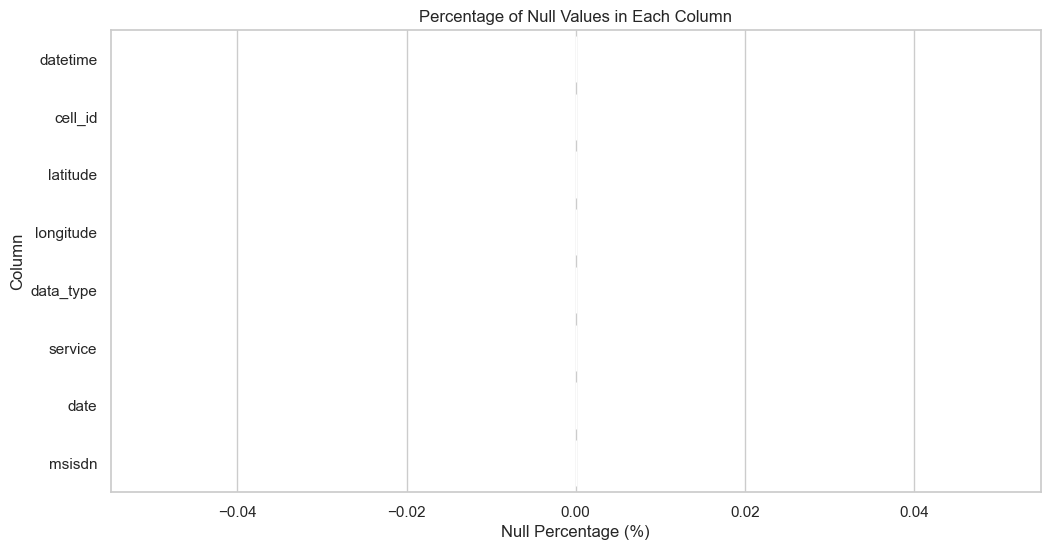

In [155]:
# Import necessary libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the grid and create a new figure with a given size
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot a stacked bar chart using data from `null_percentages_df`
# which contains columns and their corresponding null percentages
sns.barplot(
    x="NullPercentage", 
    y="Column", 
    data=null_percentages_df, 
    orient="h", 
    palette="Set2"
)

# Set the chart title, x-axis label, y-axis label and target path to save the image
plt.title("Percentage of Null Values in Each Column")
plt.xlabel("Null Percentage (%)")
plt.ylabel("Column")

# Set the path
targeted_path_img = QA_PATH+"2_null_percentages.png"

# Save the chart as an image file at the specified location
plt.savefig(targeted_path_img)

# Show the plotted chart
plt.show()

In [156]:
# Define the target path for storing the null_percentage data in CSV format
targeted_path_csv = QA_PATH+"2_null_percentages.csv"

# Export the `null_percentages_df` data to a CSV file at the specified location
# Set `index=False` to exclude index column and `sep= "\t"` to use tab-separation between columns
null_percentages_df.to_csv(targeted_path_csv, index=False, sep="\t")

## 3. Checking Consistency of Number of Subscribers

This metric aims to verify the consistency of the number of subscribers recorded each day in the MPD dataset. Inconsistent subscriber counts may indicate data quality issues, such as data entry errors or inconsistencies in data collection processes.

To perform this quality check, we will follow these steps:

1. Extract the relevant columns for analysis.
2. Group the data by `date` and `data_type` then calculate the count of unique subscribers for each day.
3. Identify any discrepancies or irregularities in the subscriber counts.
4. Present the results into chart.

In [157]:
import numpy as np
from pyspark.sql.functions import countDistinct

# Select the columns for analysis
subscriber_counts_df = df.select("date", "msisdn", "data_type").dropDuplicates()

# Group the dataset by 'date' and 'data_type' then count the number of unique subscribers for each day
subscriber_counts_df = subscriber_counts_df\
    .groupBy('date','data_type')\
    .agg(
        countDistinct('msisdn').alias('subscriber_count')
    )

# Calculate the minimum and maximum subscriber counts
min_count = subscriber_counts_df.agg({'subscriber_count': 'min'}).collect()[0][0]
max_count = subscriber_counts_df.agg({'subscriber_count': 'max'}).collect()[0][0]

# Check if there are any discrepancies or irregularities in the subscriber counts
user_consistency_report = ""

if (min_count/max_count)<QA_CONF['SUBS_MIN_THRESHOLD']:
    user_consistency_report = 'Discrepancies or irregularities found in the daily subscriber counts, within range {} - {} (ratio: {:.2f}%).'.format(min_count,max_count,min_count/max_count*100)
    user_consistency_report = ("FAILED",user_consistency_report)
else:
    user_consistency_report = 'Daily subscriber counts are relatively consistent, within range {} - {} (ratio: {:.2f}%).'.format(min_count,max_count,min_count/max_count*100)
    user_consistency_report = ("PASSED",user_consistency_report)

print(user_consistency_report)
QA_summary['USER_CONSISTENCY_REPORT'] = user_consistency_report

('FAILED', 'Discrepancies or irregularities found in the daily subscriber counts, within range 1 - 98 (ratio: 1.02%).')


In [158]:
# Display the subscriber counts for each day
subscriber_counts_df.orderBy('date').show()

+----------+---------+----------------+
|      date|data_type|subscriber_count|
+----------+---------+----------------+
|2024-05-10|     IPDR|              76|
|2024-05-10|      CDR|              24|
|2024-05-11|     IPDR|              88|
|2024-05-11|      CDR|              37|
|2024-05-12|     IPDR|              81|
|2024-05-12|      CDR|              35|
|2024-05-13|     IPDR|              87|
|2024-05-13|      CDR|              42|
|2024-05-14|      CDR|              44|
|2024-05-14|     IPDR|              88|
|2024-05-15|      CDR|              38|
|2024-05-15|     IPDR|              84|
|2024-05-16|      CDR|              46|
|2024-05-16|     IPDR|              92|
|2024-05-17|     IPDR|              82|
|2024-05-17|      CDR|              41|
|2024-05-18|      CDR|              50|
|2024-05-18|     IPDR|              89|
|2024-05-19|     IPDR|              83|
|2024-05-19|      CDR|              41|
+----------+---------+----------------+
only showing top 20 rows



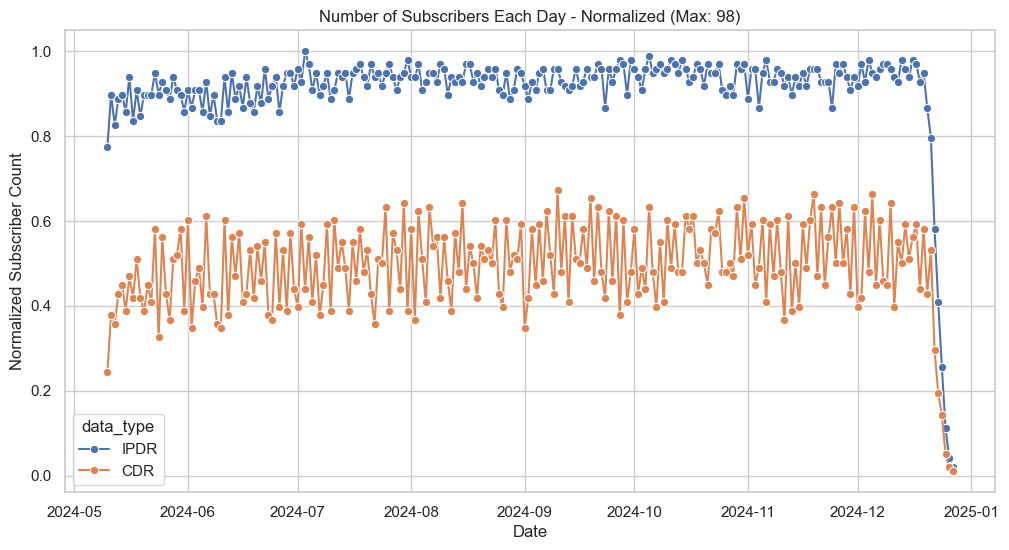

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the subscriber counts DataFrame to Pandas DataFrame for visualization
subscriber_counts_pd = subscriber_counts_df.toPandas().sort_values('date')

subscriber_counts_pd['subscriber_count_norm'] = subscriber_counts_pd['subscriber_count']/max_count

# Plot the line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=subscriber_counts_pd, x='date', y='subscriber_count_norm', hue='data_type',marker="o")

# Set the chart title and labels
plt.title('Number of Subscribers Each Day - Normalized (Max: {})'.format(max_count))
plt.xlabel('Date')
plt.ylabel('Normalized Subscriber Count')

# Set the path
targeted_path_img = QA_PATH+"3_number_of_subscribers_daily.png"

# Save the chart as an image file at the specified location
plt.savefig(targeted_path_img)

# Show the chart
plt.show()

In [160]:
# Define the target path for storing the null_percentage data in CSV format
targeted_path_csv = QA_PATH+"3_number_of_subscribers_daily.csv"

# Export the `subscriber_counts_pd` data to a CSV file at the specified location
# Set `index=False` to exclude index column and `sep= "\t"` to use tab-separation between columns
subscriber_counts_pd.to_csv(targeted_path_csv, index=False, sep="\t")

## 4. Checking Consistency of the Number of Unique Cell Locations

This metric aims to examine the consistency of the count of unique cell locations in the MPD dataset. Consistent counts indicate a reliable dataset, while inconsistencies may suggest data quality issues or errors in recording cell locations.

### Steps:
1. Extract the relevant columns for analysis.
2. Group the dataset by the `date` and `data_type` column and count the number of unique cell locations ('cell_id') for each day.
3. Analyze the count of unique cell locations for any discrepancies or irregularities.
4. Present the results into chart.

In [161]:
from pyspark.sql.functions import countDistinct

# Select the columns for analysis (date and number of subscribers)
cell_location_counts_df = df.select("date", "cell_id", "data_type").dropDuplicates()

# Group the dataset by 'date' and count the number of unique cell location for each day
cell_location_counts_df = cell_location_counts_df.groupBy('date','data_type').agg(countDistinct('cell_id').alias('cell_count'))

# Calculate the minimum and maximum cell location counts
min_count = cell_location_counts_df.agg({'cell_count': 'min'}).collect()[0][0]
max_count = cell_location_counts_df.agg({'cell_count': 'max'}).collect()[0][0]

# Check if there are any discrepancies or irregularities in the subscriber counts
cell_consistency_report = ""

if (min_count/max_count)<QA_CONF['CELL_MIN_THRESHOLD']:
    cell_consistency_report = 'Discrepancies or irregularities found in the cell counts, within range {} - {}.'.format(min_count,max_count)
    cell_consistency_report = ("FAILED",cell_consistency_report)
else:
    cell_consistency_report = 'Cell counts are relatively consistent, within range {} - {}.'.format(min_count,max_count)
    cell_consistency_report = ("PASSED",cell_consistency_report)

QA_summary["CELL_CONSISTENCY_REPORT"] = cell_consistency_report
print("CHECKING RESULT:\n{}".format(cell_consistency_report))

CHECKING RESULT:
('FAILED', 'Discrepancies or irregularities found in the cell counts, within range 1 - 249.')


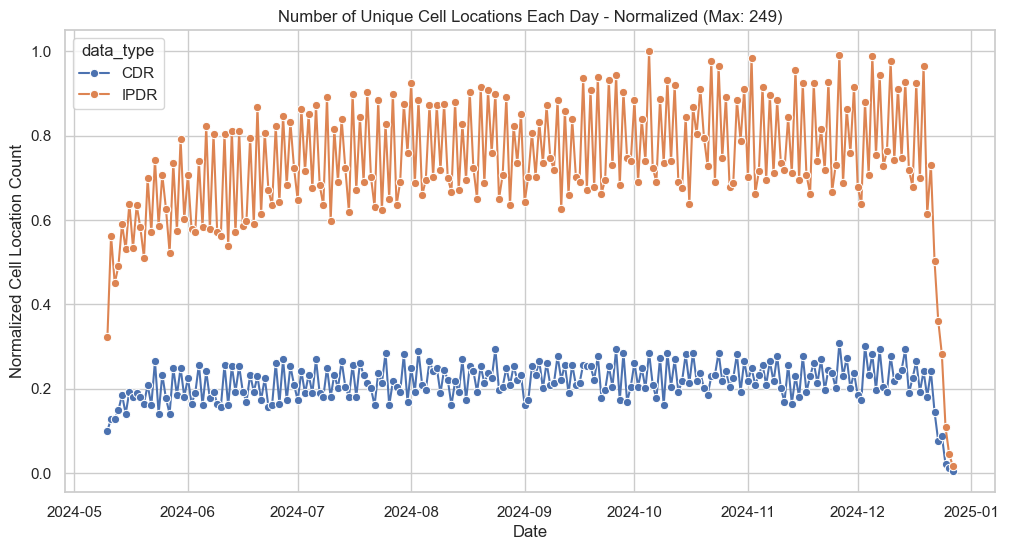

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the subscriber counts DataFrame to Pandas DataFrame for visualization
cell_location_counts_pd = cell_location_counts_df.toPandas().sort_values('date')

cell_location_counts_pd['cell_count_norm'] = cell_location_counts_pd['cell_count']/max_count

# Plot the line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=cell_location_counts_pd, x='date', y='cell_count_norm', hue='data_type', marker="o")

# Set the chart title and labels
plt.title('Number of Unique Cell Locations Each Day - Normalized (Max: {})'.format(max_count))
plt.xlabel('Date')
plt.ylabel('Normalized Cell Location Count')

# Set the path
targeted_path_img = QA_PATH+"4_number_of_cells_daily.png"

# Save the chart as an image file at the specified location
plt.savefig(targeted_path_img)

# Show the chart
plt.show()

In [163]:
# Define the target path for storing the null_percentage data in CSV format
targeted_path_csv = QA_PATH+"4_number_of_cells_daily.csv"

# Export the `cell_location_counts_pd` data to a CSV file at the specified location
# Set `index=False` to exclude index column and `sep= "\t"` to use tab-separation between columns
cell_location_counts_pd.to_csv(targeted_path_csv, index=False, sep="\t")

## 5. Checking the Location of Cell IDs

The purpose of this metric is to analyze the location of cell IDs in the MPD dataset and identify any cell IDs that are located outside the mainland. Cell IDs outside the mainland may indicate data errors or inconsistencies, as they are expected to be within the geographical boundaries of the region of interest.

### Steps:
1. **Get the list of unique cell_id with latitude and longitude**: To analyze the location of cell IDs, we first extract a list of unique cell IDs from the MPD dataset along with their corresponding latitude and longitude coordinates. This information is essential for mapping the cell tower locations.

2. **Create a folium map of cell tower locations using the `folium` package**: The next step involves visualizing the cell tower locations on a map. We utilize the `folium` package, which provides a user-friendly interface for creating interactive maps. By using the latitude and longitude coordinates obtained in the previous step, we can plot the cell tower locations on the map. In this case, the focus is on Brazilian cell tower locations.

In [164]:
# Dropping all rows with duplicate entries for `cell_id`, `latitude`, and `longitude` columns, then converting it into a Pandas dataframe 
df_cell = df.select(['cell_id','latitude','longitude']).dropDuplicates().toPandas()

# Displaying the resulting Pandas dataframe `df_cell`.
df_cell

cell_id   latitude  longitude
0     146.0  43.236000     -3.167
1      73.0  43.222000     -3.184
2     113.0  43.200001     -3.174
3     422.0  43.339001     -3.122
4      95.0  43.222000     -3.178
..      ...        ...        ...
919   858.0  43.328999     -3.078
920   875.0  43.328999     -3.077
921   795.0  43.330002     -3.083
922   780.0  43.330002     -3.085
923   845.0  43.328999     -3.079

[924 rows x 3 columns]

In [165]:
adm_boundaries.to_file("../data/spain_adm.json",driver="GeoJSON")

In [166]:
# Importing geopandas and shapely.geometry libraries 
import geopandas as gpd
from shapely.geometry import Point

GEOJSON_FILE = "../data/spain_adm.json"
# GEOJSON_FILE = "../data/brazil_adm.json"

# Providing the path to the GeoJSON file containing administrative boundaries. 
# for this example we will use administrative boundaries of Rio De Janeiro, Brazil.
# Reading the data from the GeoJSON file into a geopandas dataframe named `adm_boundaries`
adm_boundaries = gpd.read_file(GEOJSON_FILE)
adm_boundaries = adm_boundaries.rename(columns={'name':'nm_municip'})

# Displaying the resulting geopandas dataframe `adm_boundaries`.
adm_boundaries

id               nm_municip  \
0     39001         Alfoz de Lloredo   
1     16177                   Reíllo   
2     16181        Rozalén del Monte   
3     16185         Saceda-Trasierra   
4     49069     Figueruela de Arriba   
...     ...                      ...   
8200  38047                 Tijarafe   
8201  38048                 Valverde   
8202  38049           Valle Gran Rey   
8203  38050             Vallehermoso   
8204  38051  La Victoria de Acentejo   

                                               geometry  
0     POLYGON ((-4.26414 43.36484, -4.23718 43.36161...  
1     POLYGON ((-1.95651 39.87532, -1.94078 39.91570...  
2     POLYGON ((-2.83058 40.00940, -2.80137 40.01263...  
3     POLYGON ((-2.88675 40.16449, -2.86204 40.20004...  
4     POLYGON ((-6.54706 41.93026, -6.53807 41.92541...  
...                                                 ...  
8200  POLYGON ((-17.99311 28.73952, -17.95266 28.750...  
8201  MULTIPOLYGON (((-18.02456 27.72820, -17.98861 ...  
8202  POLYGON ((-17.34149 28.15470, -17.32126 28.143...  
8203  POLYGON ((-17.34149 28.15470, -17.33699 28.174...  
8204  MULTIPOLYGON (((-16.48764 28.43742, -16.47416 ...  

[8205 rows x 3 columns]

In [167]:
# Define a function to get administrative location for a given lat, long point
def get_admin_location(lat, long, col_name="nm_municip"):
    # Create a shapely Point object from the lat, long coordinates
    point = Point(long, lat)
    
    try:
        # Use GeoPandas' spatial join to find the administrative location that contains the point
        result = gpd.sjoin(adm_boundaries, gpd.GeoDataFrame(geometry=[point],crs='EPSG:4326'), predicate='contains')
        # result = gpd.sjoin(adm_boundaries, gpd.GeoDataFrame(geometry=[point]), predicate='contains')
        
        # Return the name of the administrative location
        return result.iloc[0][col_name]
    except:
        return "Out-of-bounds"

# test the function
get_admin_location(-22.9139,-43.2069)

'Out-of-bounds'

In [168]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()

# Assigning values to 'municipality' column of dataframe 'df_cell'
# Each value is obtained using the 'get_admin_location()' function applied to the corresponding latitude and longitude values of that row.
# 'apply()' method is used to apply a function along an axis of the DataFrame
df_cell['municipality'] = df_cell.progress_apply(lambda x: get_admin_location(x['latitude'],x['longitude']),axis=1)

# Displaying the resulting dataframe 'df_cell' with updated 'municipality' column.
df_cell.head()

100%|██████████| 924/924 [00:03<00:00, 245.81it/s]


cell_id   latitude  longitude municipality
0   146.0  43.236000     -3.167     Sopuerta
1    73.0  43.222000     -3.184     Sopuerta
2   113.0  43.200001     -3.174        Zalla
3   422.0  43.339001     -3.122       Muskiz
4    95.0  43.222000     -3.178     Sopuerta

In [169]:
# Returns the count of unique values in the 'municipality' column of df_cell 
df_cell['municipality'].value_counts()

municipality
Muskiz                               261
Abanto y Ciérvana-Abanto Zierbena    203
Castro-Urdiales                      153
Zalla                                111
Zierbena                              73
Güeñes                                43
Sopuerta                              41
Galdames                              33
Out-of-bounds                          3
Balmaseda                              2
Ortuella                               1
Name: count, dtype: int64

In [170]:
ALL_cells = len(df_cell)
OOB_cells = len(df_cell[df_cell['municipality']=='Out-of-bounds'])

cell_location_report = ""
if (OOB_cells/ALL_cells)>QA_CONF['CELL_OOB_MAX_THRESHOLD']:
    cell_location_report = 'Number of cell location outside the mainland is greater than tolerancy = {}%.'.format(OOB_cells/ALL_cells*100)
    cell_location_report = ("FAILED",cell_location_report)
else:
    cell_location_report = 'Number cell location outside the mainland is acceptable ({}%)'.format(OOB_cells/ALL_cells*100)
    cell_location_report = ("PASSED",cell_location_report)

QA_summary["CELL_LOCATION_REPORT"] = cell_location_report
print(cell_location_report)

('PASSED', 'Number cell location outside the mainland is acceptable (0.3246753246753247%)')


In [171]:
# Define the target path for storing the data
targeted_path_csv = QA_PATH+"5_cell_administrative_location.csv"

# Export the `cell_location_counts_pd` data to a CSV file at the specified location
# Set `index=False` to exclude index column and `sep= "\t"` to use tab-separation between columns
df_cell.to_csv(targeted_path_csv, index=False, sep="\t")

### Create a folium map

In [172]:
# Importing the "folium" library to create web maps.
import folium
import json

# Read the GeoJSON data using UTF-8 encoding
with open(GEOJSON_FILE, 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

df_cell_used = df_cell[df_cell['municipality']!='Out-of-bounds']

# Creating the overall cell location map by defining its initial location pointing to the first cell's latitude and longitude, along with setting its zoom level.
cell_location = folium.Map(
    location = [df_cell_used['latitude'].iloc[0], df_cell_used['longitude'].iloc[0]],
    zoom_start = 10,
    tiles= "Cartodb Positron"
)

# Adding the GeoJSON boundaries data (Brazil state borders) to the cell location map.
# The tooltip parameter displays information when hovering over the polygon.
# The style_function changes the appearance of the polygons on the map.
# The highlight_function highlights when a user clicks on a polygon.
folium.GeoJson(geojson_data, name='adm_boundaries',
               tooltip = folium.GeoJsonTooltip(fields=['nm_municip']),
               style_function = lambda feature: {'fillOpacity':0.15, 'weight':1},
               highlight_function= lambda feature: {'fillColor': 'black'}
              ).add_to(cell_location)

# Plotting each cell tower on the map obtained from the dataframe 'df_cell'.
# Iterating through each row of the dataframe and adding a marker for each cell tower.
for i, row in df_cell_used.iterrows():
    folium.Marker(
        location = [row["latitude"], row["longitude"]], # Specifying the coordinates of the marker based on its latitude and longitude.
        popup = row['cell_id'], # Displaying the tower ID as the popup message.
        icon=folium.Icon(icon='signal') # Defining the icon to use for each marker (signal).
    )\
    .add_to(cell_location) # Adding the marker to the map.

# Finally, displaying the resultant cell location map.
cell_location

## 6. Checking the Active Day Distribution of Subscribers (Day Present)

The purpose of this metric is to analyze the distribution of active days for subscribers in the MPD dataset. By examining this distribution, we can identify patterns or anomalies in subscriber activity, such as high or low usage on specific days. Understanding the active day distribution is essential for assessing the reliability and usage patterns of the mobile network.

### Steps:
1. **Group the dataset by 'msisdn' (subscriber ID) and count the number of unique 'day' values for each subscriber**: To analyze the active day distribution, we group the dataset by the 'msisdn' column (representing each subscriber) and count the number of unique 'day' values associated with each subscriber. This will give us the number of active days for each subscriber.

2. **Calculate the frequency distribution of the number of active days**: Once we have the count of active days for each subscriber, we calculate the frequency distribution of these counts. This distribution will show us the frequency (or occurrence) of different numbers of active days among subscribers.

3. **Calculate the skewness of the 'active_days_count' column of the Pandas dataframe using the stats module from the scipy library**: Skewness is a statistical measure that helps assess the symmetry of a distribution. By calculating the skewness of the 'active_days_count' column in the Pandas dataframe, we can determine if the distribution of active days is skewed to one side (positively or negatively) or if it is approximately symmetrical. This assumption will be valid if we have enough data, like minimum in one month dataset.

4. **Visualize the active day distribution using bar chart**: To gain a better understanding of the active day distribution, we can visualize it using a bar chart. This visualization will display the frequency of different numbers of active days among subscribers, allowing us to identify any patterns or anomalies in the distribution.

In [173]:
from pyspark.sql.functions import countDistinct
from scipy import stats
import numpy as np

# Group the dataset by 'msisdn' and count the number of unique 'day' values for each subscriber
active_days_df = df.groupBy('msisdn').agg(countDistinct('date').alias('active_days_count'))

# Convert the above Spark dataframe into a Pandas dataframe
active_days_pd = active_days_df.toPandas()

# Calculate the skewness of the 'active_days_count' column of the Pandas dataframe using the stats module from scipy library
skewness = stats.skew(active_days_pd['active_days_count'])

# Check if the skewness score is less than the given threshold. If yes, set the QA report as Passed, else set it as Failed.
if skewness<QA_CONF['ACTIVE_DAY_SKEWNESS_THRESHOLD']:
    active_day_distribution_report = 'Day present of the subscribers is having asymmetry distribution (long-tailed) with skewness score: {:.2f}'.format(skewness)
    active_day_distribution_report = ("PASSED",active_day_distribution_report)
else:
    active_day_distribution_report = 'Day present of the subscribers is having symmetry distribution with skewness score: {:.2f}'.format(skewness)
    active_day_distribution_report = ("FAILED",active_day_distribution_report)

# Set the active day distribution report as part of the QA summary dictionary
QA_summary['ACTIVE_DAY_DISTRIBUTION_REPORT'] = active_day_distribution_report

# Print the final active day distribution report
print(active_day_distribution_report)


('PASSED', 'Day present of the subscribers is having asymmetry distribution (long-tailed) with skewness score: -3.68')


In [174]:
# Calculate the frequency distribution of the number of active days
active_days_distribution_df = active_days_df.groupBy('active_days_count').count().orderBy('active_days_count')
active_days_distribution_df.show()

+-----------------+-----+
|active_days_count|count|
+-----------------+-----+
|               61|    1|
|              116|    1|
|              147|    1|
|              150|    1|
|              155|    1|
|              162|    1|
|              175|    1|
|              186|    1|
|              194|    2|
|              197|    2|
|              200|    1|
|              204|    1|
|              205|    1|
|              206|    2|
|              208|    1|
|              210|    1|
|              211|    1|
|              212|    2|
|              213|    1|
|              215|    1|
+-----------------+-----+
only showing top 20 rows



### Visualize the active day distribution using bar chart

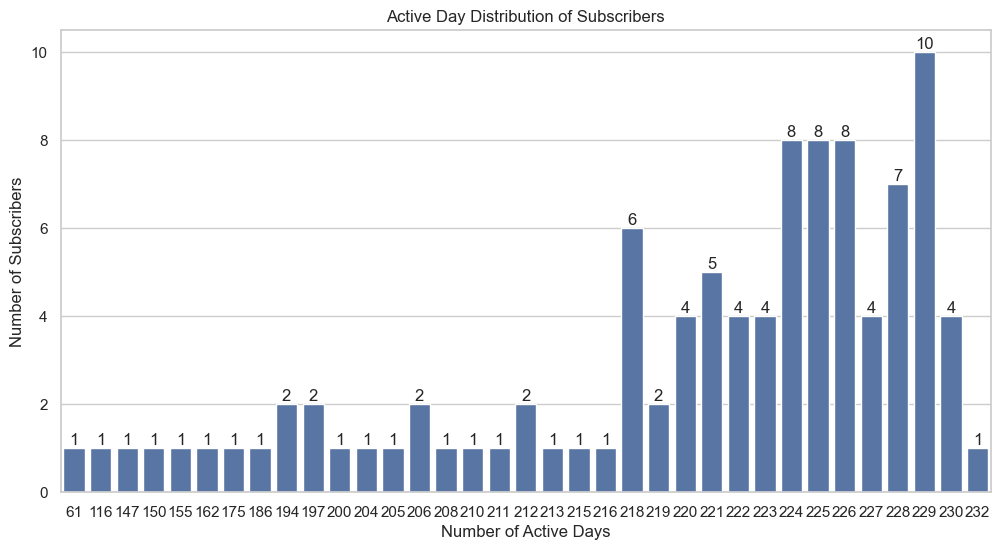

In [175]:
import seaborn as sns

# Convert the active_days_distribution_df DataFrame to Pandas DataFrame for visualization
active_days_distribution_pd = active_days_distribution_df.toPandas()

# Define the target path for storing the null_percentage data in CSV format
targeted_path_csv = QA_PATH+"6_active_day_distribution_of_subscribers.csv"

# Export the data to a CSV file at the specified location
# Set `index=False` to exclude index column and `sep= "\t"` to use tab-separation between columns
active_days_distribution_pd.to_csv(targeted_path_csv, index=False, sep="\t")

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=active_days_distribution_pd, x='active_days_count', y='count')

# Add labels inside the bars
for index, row in active_days_distribution_pd.iterrows():
    plt.text(row.name, row['count'], str(row['count']), ha='center', va='bottom')

# Set the chart title and labels
plt.title('Active Day Distribution of Subscribers')
plt.xlabel('Number of Active Days')
plt.ylabel('Number of Subscribers')

# Set the path
targeted_path_img = QA_PATH+"6_active_day_distribution_of_subscribers.png"

# Save the chart as an image file at the specified location
plt.savefig(targeted_path_img)

# Show the chart
plt.show()

### Analyzing the Day Present Bar Chart
The bar chart visualizes the active day distribution of subscribers. Each bar represents the number of subscribers with a specific number of active days. By analyzing the chart, you can identify potential patterns or anomalies in subscriber activity. Here are some points to consider:

1. **Ideal Pattern**: In an ideal scenario, you would expect a long-tail distribution,  with a larger number of subscribers having a higher number of active days. This indicates a healthy and engaged subscriber base. A distribution is skewed if one of its tails is longer than the other. So we can use skewness score smaller than -0.5 (Left Skewness) to indicate the long-tail distribution with the majority of the data is concentrated on the higher active days.

2. **Anomaly Patterns - Low Activity**: If there is a significant spike or high count of subscribers with very few active days (e.g., 1 or 2 days), it may indicate a group of subscribers who are less engaged or sporadic in their mobile usage.

## 7. Checking the Diurnal Distribution of Subscribers Activity

The purpose of this metric is to analyze the diurnal distribution of subscribers' activity throughout the day. By examining this distribution, we can identify peak usage hours, low-usage periods, or any abnormal patterns in subscribers' activity. This analysis is valuable for understanding user behavior and usage trends, which can be used to optimize network resources.

### Steps:
1. **Add a new column 'hour' to the existing dataframe 'df'**: To perform the diurnal distribution analysis, we need to extract the hour information from the timestamp data in our dataframe. By adding a new column 'hour' to the existing dataframe 'df', we can store the hour component of each timestamp.

2. **Group the dataset by the 'msisdn' column and count the number of occurrences for each hour of the day**: To understand the distribution of subscriber activity throughout the day, we group the dataset by the 'msisdn' column (representing each subscriber) and count the number of occurrences for each hour of the day. This will give us the frequency of activity for each hour.

3. **Perform Mann-Whitney U test to compare the diurnal distribution in the data with the reference distribution**: To determine if the diurnal distribution in our data significantly differs from a reference distribution, we use the` Mann-Whitney U test`. This statistical test helps us compare two independent samples (our diurnal distribution and the reference distribution) and assess if there is a significant difference in the distributions.

4. **Visualize the diurnal distribution of subscribers activity using a bar chart**: To gain a better understanding of the diurnal distribution, we visualize it using a bar chart. This chart will display the frequency of subscribers' activity for each hour of the day, allowing us to easily identify peak usage hours, low-usage periods, and any abnormal patterns.

By following these steps, we can analyze the diurnal distribution of subscribers activity and gain insights into user behavior and usage trends.

In [176]:
df.show()

+-------------------+-------+--------+---------+---------+-------+----------+------+
|           datetime|cell_id|latitude|longitude|data_type|service|      date|msisdn|
+-------------------+-------+--------+---------+---------+-------+----------+------+
|2024-11-04 00:04:00|  100.0|  43.209|   -3.177|      CDR|     2G|2024-11-04|    48|
|2024-11-04 06:38:00|  100.0|  43.209|   -3.177|      CDR|     2G|2024-11-04|    48|
|2024-11-04 00:36:00|  100.0|  43.209|   -3.177|      CDR|     2G|2024-11-04|    48|
|2024-11-04 05:07:00|  100.0|  43.209|   -3.177|      CDR|     2G|2024-11-04|    48|
|2024-11-04 03:44:00|  100.0|  43.209|   -3.177|      CDR|     2G|2024-11-04|    48|
|2024-11-04 05:28:00|  100.0|  43.209|   -3.177|      CDR|     2G|2024-11-04|    48|
|2024-05-20 11:30:00|  119.0|  43.221|   -3.172|     IPDR|     3G|2024-05-20|    48|
|2024-05-20 05:59:00|  119.0|  43.221|   -3.172|     IPDR|     3G|2024-05-20|    48|
|2024-06-03 22:54:00|  119.0|  43.221|   -3.172|     IPDR|     3G

In [177]:
from pyspark.sql.functions import month, hour, count, col

# Add a new column 'hour' to the existing dataframe 'df'
# This new column stores only the hour part of the 'datetime' column of 'df'.
df = df.withColumn('hour',hour('datetime'))\
    .withColumn('month',month('datetime'))

# Default configuration, will use all input data
filtered_df = df

# Filtered the data into specific date for more advanced analysis.
# You can activate this by setting the start_date and end_date, then removing the command
# start_date = "2023-05-01"
# end_date = "2023-05-03"
# filtered_df = df.filter(col('date').between(start_date,end_date))

filtered_df.groupBy('date').count().sort('date').show()

+----------+-----+
|      date|count|
+----------+-----+
|2024-05-10|  606|
|2024-05-11|  988|
|2024-05-12|  780|
|2024-05-13|  775|
|2024-05-14|  961|
|2024-05-15|  757|
|2024-05-16|  983|
|2024-05-17|  749|
|2024-05-18|  914|
|2024-05-19|  783|
|2024-05-20|  747|
|2024-05-21|  937|
|2024-05-22|  692|
|2024-05-23| 1094|
|2024-05-24|  764|
|2024-05-25| 1106|
|2024-05-26|  764|
|2024-05-27|  755|
|2024-05-28| 1065|
|2024-05-29|  832|
+----------+-----+
only showing top 20 rows



In [178]:
# Group the dataset by 'msisdn' and 'hour' and count the occurrences
diurnal_distribution_pd = filtered_df.groupBy('hour','data_type')\
    .agg(count('*').alias('activity_count'))\
    .toPandas().sort_values('hour')

# Define the target path for storing the null_percentage data in CSV format
targeted_path_csv = QA_PATH+"7_diurnal_distribution_of_subscribers_activity.csv"

# Export the data to a CSV file at the specified location
# Set `index=False` to exclude index column and `sep= "\t"` to use tab-separation between columns
diurnal_distribution_pd.to_csv(targeted_path_csv, index=False, sep="\t")

# Select all rows from the diurnal_distribution_pd dataframe where data_type is 'CDR'
diurnal_cdr = diurnal_distribution_pd[diurnal_distribution_pd['data_type']=='CDR'].reset_index(drop=True)

# Normalize the activity_count column in the new diurnal_cdr dataframe 
# by dividing each value with the maximum value of activity_count column
diurnal_cdr['activity_count'] = diurnal_cdr['activity_count']/np.max(diurnal_cdr['activity_count'])

# Select all rows from the diurnal_distribution_pd dataframe where data_type is 'IPDR'
diurnal_ipdr = diurnal_distribution_pd[diurnal_distribution_pd['data_type']=='IPDR'].reset_index(drop=True)

# Normalize the activity_count column in the new diurnal_ipdr dataframe 
# by dividing each value with the maximum value of activity_count column
diurnal_ipdr['activity_count'] = diurnal_ipdr['activity_count']/np.max(diurnal_ipdr['activity_count'])


### Perform Mann-Whitney U test to compare the diurnal distribution in the data with the reference distribution

In [179]:
# Importing 'stats' module from 'scipy' library
from scipy import stats

# Perform Mann-Whitney U test to compare two samples and calculate the p-value
# for CDR's diurnal distribution against the reference distribution
_, p_value_cdr = stats.mannwhitneyu(QA_CONF['DIURNAL_DISTRIBUTION_REFERENCE'], diurnal_cdr['activity_count'], alternative='two-sided')

# Perform Mann-Whitney U test to compare two samples and calculate the p-value
# for IPDR's diurnal distribution against the reference distribution
_, p_value_ipdr = stats.mannwhitneyu(QA_CONF['DIURNAL_DISTRIBUTION_REFERENCE'], diurnal_ipdr['activity_count'], alternative='two-sided')

# Set a flag indicating whether the check was passed or failed, and update the 
# corresponding check message string accordingly.
flag_passed = "PASSED"
if p_value_cdr<QA_CONF['DIURNAL_DISTRIBUTION_PVALUE']:
    cdr_diurnal_check = "Diurnal distribution from CDR is not following the elephant shape with p-value: {:.4f}".format(p_value_cdr)
    flag_passed = "FAILED"
else:
    cdr_diurnal_check = "Diurnal distribution from CDR is following the elephant shape with p-value: {:.4f}".format(p_value_cdr)

if p_value_ipdr<QA_CONF['DIURNAL_DISTRIBUTION_PVALUE']:
    ipdr_diurnal_check = "Diurnal distribution from IPDR is not following the elephant shape with p-value: {:.4f}".format(p_value_ipdr)
    flag_passed = "FAILED"
else:
    ipdr_diurnal_check = "Diurnal distribution from IPDR is following the elephant shape with p-value: {:.4f}".format(p_value_cdr)

# Combine the results of both checks and set the 'DIURNAL_DISTRIBUTION_REPORT' key in the
# 'QA_summary' dictionary with a tuple containing the flag and combined check messages.
diurnal_distribution_report = (flag_passed,("{}\n{}".format(cdr_diurnal_check,ipdr_diurnal_check)))
QA_summary["DIURNAL_DISTRIBUTION_REPORT"] = diurnal_distribution_report

# Print the summary report for diurnal distribution check
print(diurnal_distribution_report[0])
print(diurnal_distribution_report[1])


PASSED
Diurnal distribution from CDR is following the elephant shape with p-value: 0.9671
Diurnal distribution from IPDR is following the elephant shape with p-value: 0.9671


### Visualize the diurnal distribution of subscribers activity using a bar chart

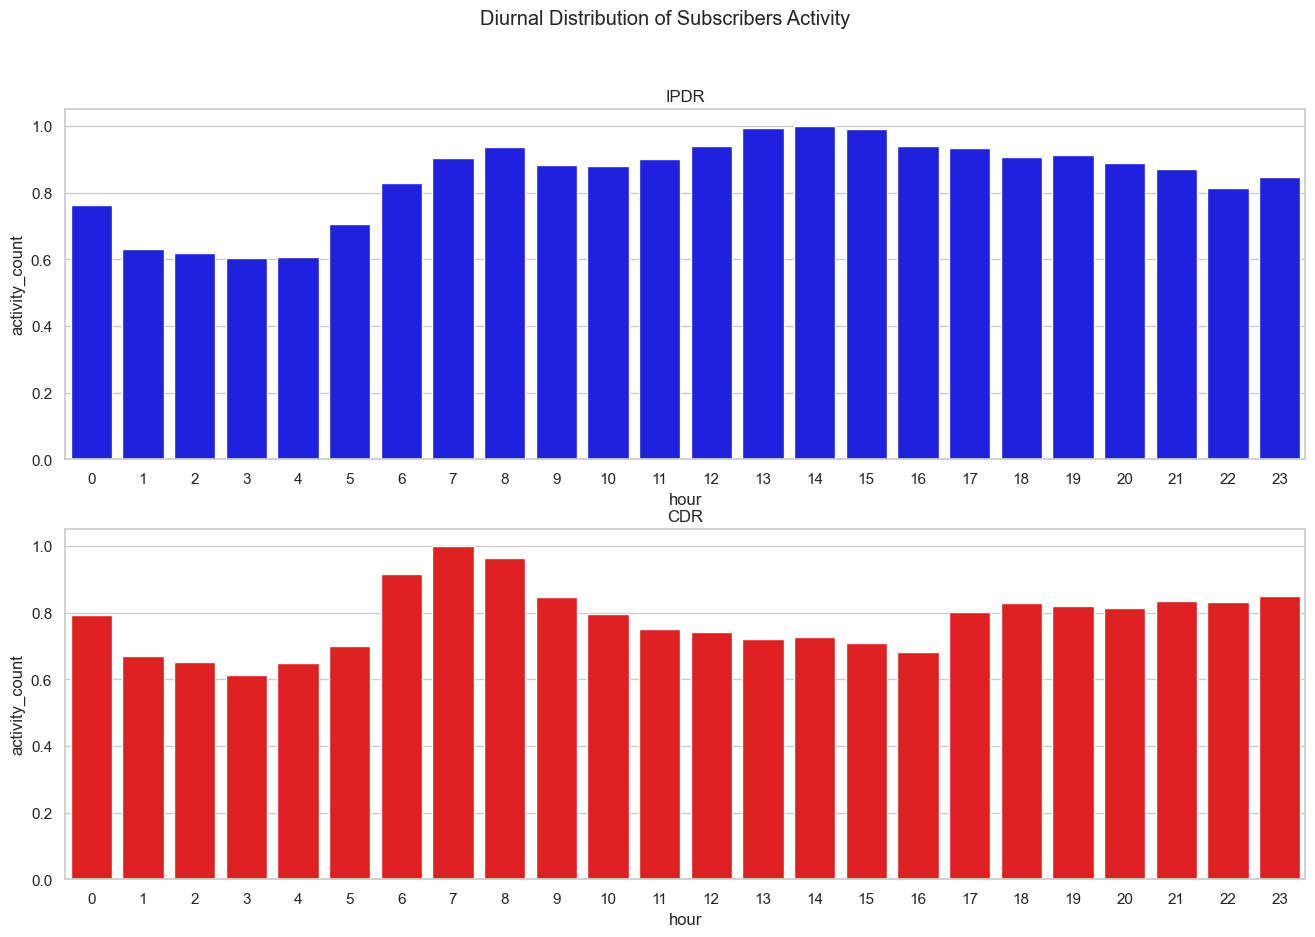

In [180]:
import seaborn as sns

# Plot the bar chart
# plt.figure(figsize=(12, 12))
fig, axes = plt.subplots(2, 1,figsize=(16, 10))
fig.suptitle('Diurnal Distribution of Subscribers Activity')
sns.barplot(ax=axes[0],data=diurnal_ipdr, x='hour', y='activity_count',color='blue')
axes[0].set_title("IPDR")

sns.barplot(ax=axes[1],data=diurnal_cdr, x='hour', y='activity_count',color='red')
axes[1].set_title("CDR")

# Set the path
targeted_path_img = QA_PATH+"7_diurnal_distribution_of_subscribers_activity.png"

# Save the chart as an image file at the specified location
plt.savefig(targeted_path_img)

# Show the chart
plt.show()

### Analyzing the Diurnal Distribution Bar Plot:

The bar plot represents the diurnal distribution of subscribers activity throughout the day. Each bar represents an hour of the day, and the height of the bar indicates the number of occurrences or activity count during that hour.

When analyzing the bar plot, consider the following points:

- **Ideal distribution**: In an ideal scenario, the diurnal distribution should follow an `"elephant shape"` pattern, where the activity count is highest during working hours and gradually decreases during non-working hours. This reflects typical usage patterns, with higher activity during the day and lower activity during the night.

- **Anomalies and patterns**: Look for any anomalies or patterns that deviate from the expected distribution. These may include:

  - `Flat pattern`: Unexpectedly similar counts of events in every hour indicates anomalies or abnormal data collection. It could be due to algorithmic data generation, record sampling, or other factors that drive unusual subscriber behavior.

  - `Spikes or peaks`: Unexpectedly high activity counts during specific hours might indicate anomalies or abnormal patterns of usage. It could be due to events, promotions, or other factors that drive unusual subscriber behavior.

  - `Inverse pattern`: Unexpectedly high activity counts during non-working hours indicating potential problem with the timezone setting in the timestamp.

In [181]:
# Close spark connection
spark.stop()

## Generate the QA Report

Finally, this code saves a Quality Assurance (QA) report to a file named "MPD_QA_Report.txt", using the current date and time in its name, then opens it in write mode. The standard output is redirected to the new file, and the header information for the QA report is printed with the current date and time. Then, the code iterates over the items in the `QA_summary` dictionary, printing out the flag value, check message, and explanation for each check.

In [182]:
# Importing 'sys' and 'datetime' modules
import sys 
import datetime

OVERALL_QA_STATUS = True

# Get the current date and time, and use it to create a unique filename for the QA report.
current_datetime = datetime.datetime.now()
filename = QA_PATH+"{}_MPD_QA_Report.txt".format(current_datetime.strftime('%Y%m%d'))

# Open the file in write mode, redirect standard output to the new file,
# and print the header information for the QA report.
with open(filename, "w") as file:
  original_stdout = sys.stdout
  sys.stdout = file
  print("-- MPD QUALITY ASSURANCE REPORT --\nCreated Time: {}\n".format(current_datetime))

  # Checking the overall result of QA
  for key,values in QA_summary.items():
    if(values[0]=="FAILED"):
      OVERALL_QA_STATUS = False
      break
        
  if OVERALL_QA_STATUS==True:
    print("SUMMARY:\nAll metrics passed the criteria. No metrics with status FAILED were identified during the quality assurance process.")
  else:
    print("SUMMARY:\nSome metrics not passed the criteria. Please check your data!!\n")
    for key,values in QA_summary.items():
      if(values[0]=="FAILED"):
        print("- {} -> {}".format(key,values[0]))
  
  # Iterate over the items in the QA_summary dictionary, and print out
  # the flag value, check message, and explanation for each check.
  print("\n\nDETAILED METRICS:")
  for key,values in QA_summary.items():
    print("\n{} -> {}\nExplanation:\n{}".format(key,values[0],values[1]))
    if(values[0]!="PASSED"):
        print("Action plan:\n{}".format(QA_action_plan[key]))

  # Reset standard output back to the original stream.
  sys.stdout = original_stdout